# Chicago Taxi Trips - Clustering
---
In this notebook, we use clustering algorithms to find different types of taxi trip patterns and cluster them as various
customer types.
These findings can be used for marketing purposes and managerial decisions, taken by the taxi companies of Chicago.
To identify these clusters, we take soft- and hard-clustering approaches with bi- and multi-dimensional feature
dimensions.
The results get visualized with the help of different types of visualizations, adapted to the observed dimension degree.

We proceeded as follows:

- Data preparation
- Soft-Clustering
    - Gaussian Mixture Model (GMM)
    - Determine number of clusters with BIC-and Silhouette-Analysis
    - Run GMM / Result Visualization
- Hard-Clustering
    - Determine number of clusters with Elbow-Method
    - Run k-Means-Algorithm / result visualization
- Compare results and identify customer types
- Conclusion and outlook

In [1]:
%cd ..

/Users/christianbergen/Documents/prog/aaa21


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import feature_engineering
import clustering
import utils
from PIL import Image as pilim

/opt/anaconda3/envs/aaa21_env/lib/python3.8/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


### Data Preparation
---

First we load our dataset and choose only columns, which we use for our clustering approaches.

In [3]:
chicago_df = utils.read_parquet('chicago_taxi_trips_15percent_sample.parquet',
                                columns=['Trip Kilometers', 'Trip Minutes', 'Trip Start Hour'])

In [4]:
#Run only if you want smaller dataset to lower runtimes
#chicago_df = chicago_df.sample(frac =0.1)

Even though the loaded dataset is already cleaned, we further drop the top 5 % quantile of the trip
distance and duration columns, to get rid of additional outliers. This helps us to build more
homogeneous clusters and deletes clusters of outliers, which differ too much from the remaining data points.

In [5]:
#Drop quantiles
chicago_df_q = chicago_df[(chicago_df['Trip Kilometers'] < chicago_df['Trip Kilometers'].quantile(0.95))]
chicago_df_q = chicago_df_q[(chicago_df_q['Trip Minutes'] < chicago_df_q['Trip Minutes'].quantile(0.95))]



In [6]:
# Drop unrealistic fast trips
chicago_df_q["kmh"] = (chicago_df_q["Trip Kilometers"]/(chicago_df_q["Trip Minutes"]/60)).round(2)
chicago_df_q = chicago_df_q[(chicago_df_q['kmh'] < chicago_df_q['kmh'].quantile(0.95))]
chicago_df_q = chicago_df_q[(chicago_df_q['kmh'] > chicago_df_q['kmh'].quantile(0.05))]
chicago_df_q = chicago_df_q.drop(['kmh'], axis = 1)

In [7]:
col_dict={
            "categorical_features": [],
            "cyclical_features": [],
            "numerical_features": [],
}
chicago_df_q = clustering.transform_columns(chicago_df_q, col_dict)

In [8]:
chicago_df_q.head()

,Trip Kilometers,Trip Minutes,Trip Start Hour
0,3.70,17.0000,17
1,1.77,6.0000,21
4,3.06,11.0000,9
5,2.41,11.0000,13
6,2.41,13.7167,9


### Soft-Clustering
---

#### Gaussian Mixture Model (GMM)

The Gaussian Mixture Model is a probabilistic model.
It creates k numbers of Gaussian Distributions and computes the probability of each data point belonging to
each of the distributions.
Each distribution equals one cluster.
But before clustering our dataset, we need to find a good fit of k for our data.

#### Determine number of clusters with BIC and Silhouette-Analysis

The Bayesian information criterion (BIC) and the Silhouette-Analysis are benchmarks, providing appropriate
numbers of clusters (k) for the given dataset.
We perform both approaches for the purpose of cross-validation and computed them with
10% dataframe size because of very long computation time.

Based on the Gaussian Distributions generated by the GMM, the BIC-Score is being computed based on the Log-
Likelihood distance.
It penalises high model complexity to avoid over-fitting of clusters.
The lower the BIC-Score for k-clusters is, the more optimal is k.

In [ ]:
scoring_df = chicago_df_q.sample(frac =0.1, random_state=7)

In [9]:
#Live version -> Very Long runtime
#clustering.get_bic(scoring_df , 8)

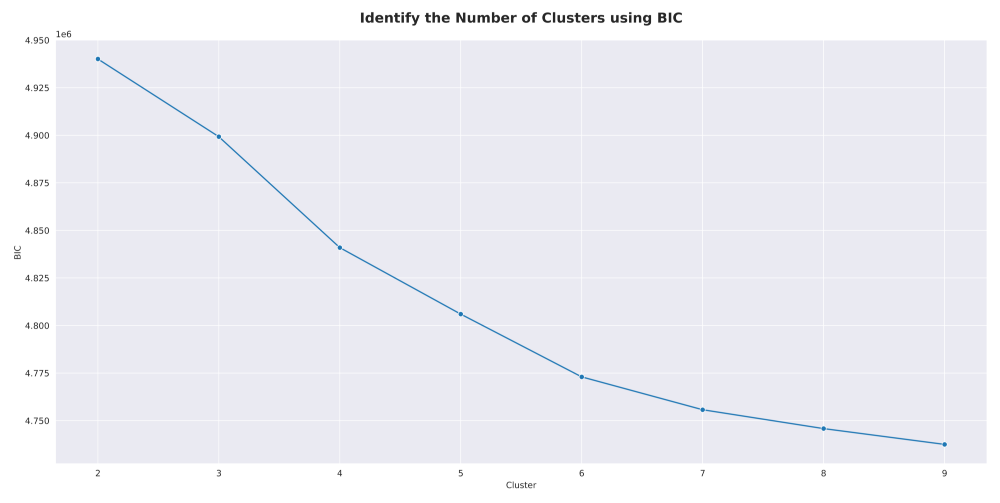

In [10]:
##Offline version -> Calculated with 10% data size
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))
bic_graph = pilim.open('img/BIC_8.png', 'r')
ax.imshow(np.asarray(bic_graph))
ax.set_axis_off()
plt.show()

The Silhouette-Analysis is another method to determine the optimal k.
It returns a value in a range of [-1, 1] per cluster, which is calculated by distance of samples within their
clusters and distance to the next nearest cluster.
The higher the computed score, the better fits the number of k clusters.

In [ ]:
#Live version -> Very Long runtime
#clustering.get_silhouette_score(scoring_df , 8)

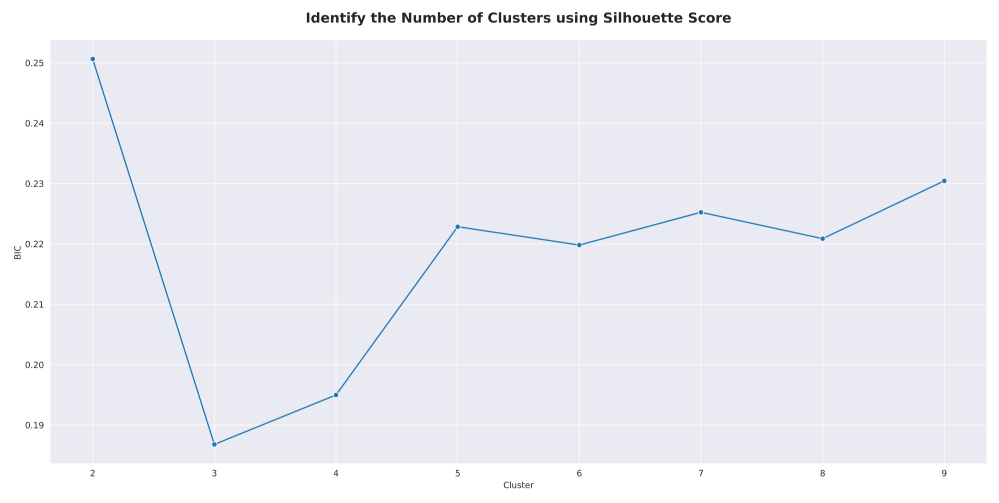

In [12]:
##Offline version -> Calculated with 10% data size
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))
sil_graph = pilim.open('img/Sil_8.png', 'r')
ax.imshow(np.asarray(sil_graph))
ax.set_axis_off()
plt.show()

The BIC score, calculated for 9 iterations, shows a decreasing curve.
Since taking too many clusters is not useful, and the curve begins to flatten after 6 iterations,
taking 6 clusters seems a decent choice.
The Silhouette Score shows a more wavy graph.
Looking at the score for 6 clusters indicates, that this should be fine choice.
The score is pretty even among 5 to 9 clusters and is much lower for 3 and 4 for clusters.

This cross-validates a number of 6 clusters for the following soft-cluster analysis.

#### Run GMM / Result Visualization

In [ ]:
# create copy of chicago_df_q to keep save from unintentional changes

gmm_df = chicago_df_q.copy()
gmm.df.info()

In [13]:
gmm_df = clustering.get_clusters_gmm(gmm_df,
                 n_cluster=6,
                 )

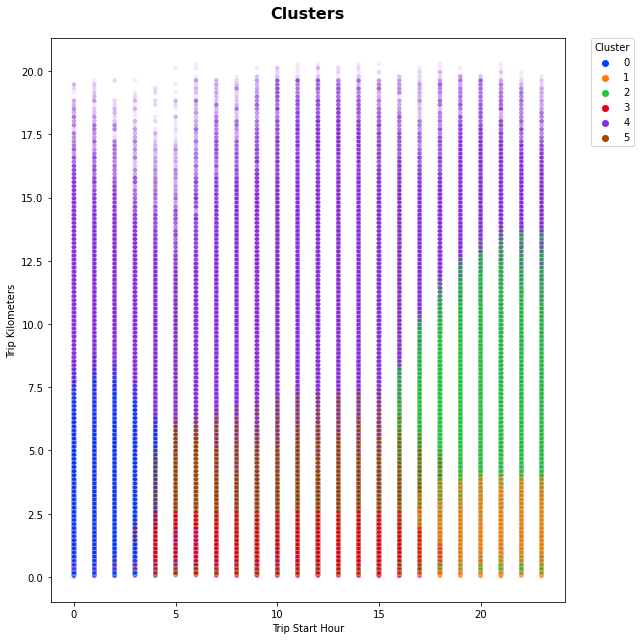

In [14]:
clustering.plot_clusters_scatter(gmm_df, "Trip Start Hour", "Trip Kilometers", "Clusters")

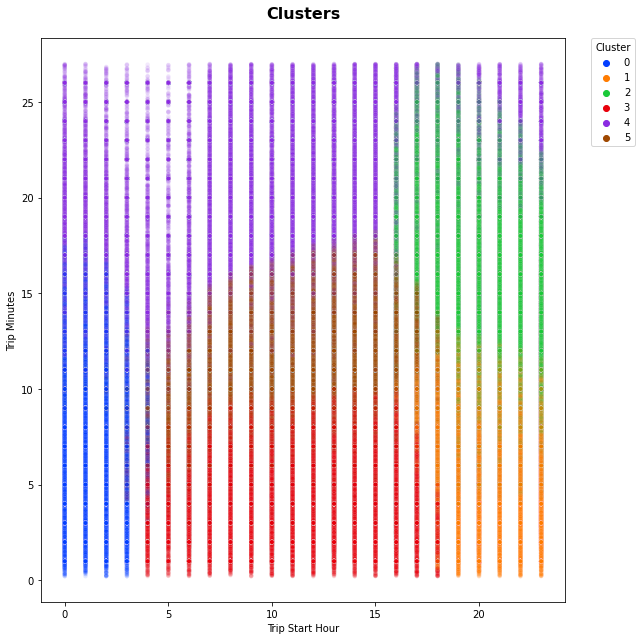

In [15]:
clustering.plot_clusters_scatter(gmm_df, "Trip Start Hour", "Trip Minutes", "Clusters")

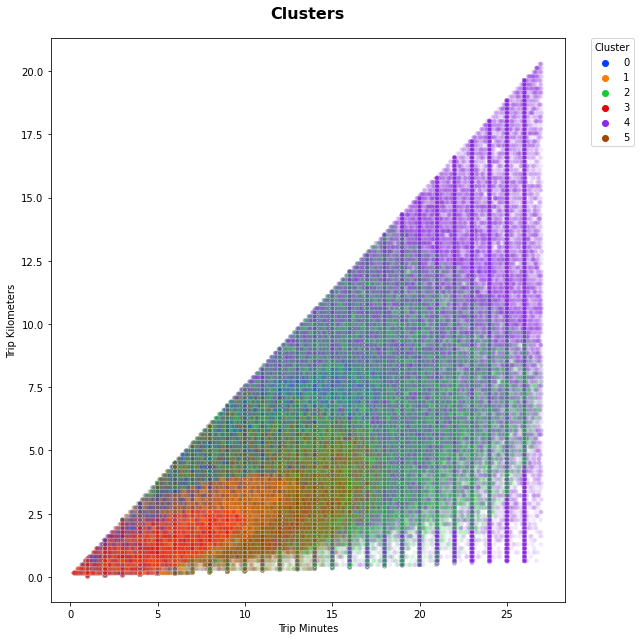

In [16]:
clustering.plot_clusters_scatter(gmm_df, "Trip Minutes", "Trip Kilometers", "Clusters")

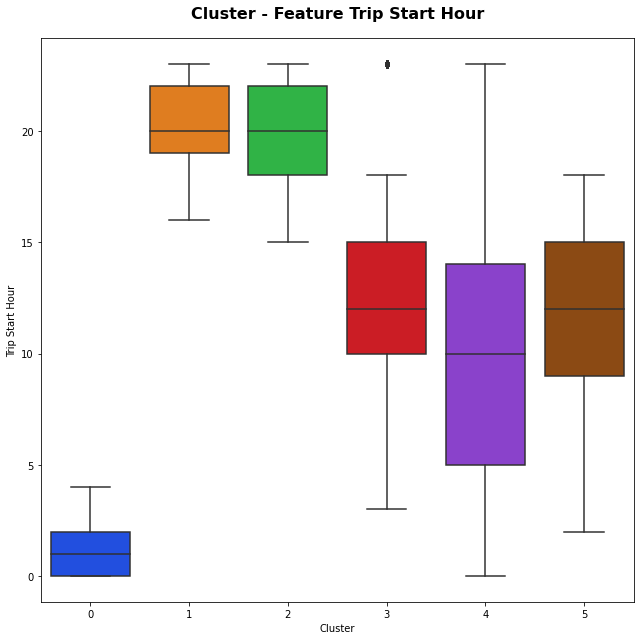

In [17]:
clustering.plot_clusters_boxplot(gmm_df, "Trip Start Hour")

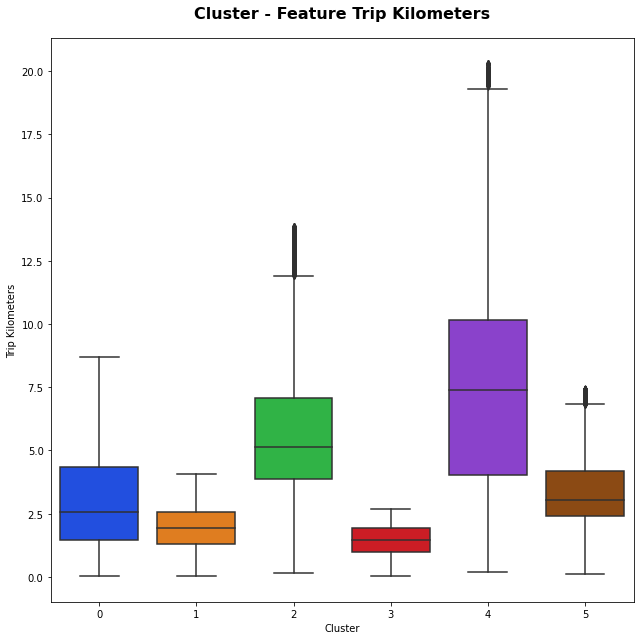

In [18]:
clustering.plot_clusters_boxplot(gmm_df, "Trip Kilometers")

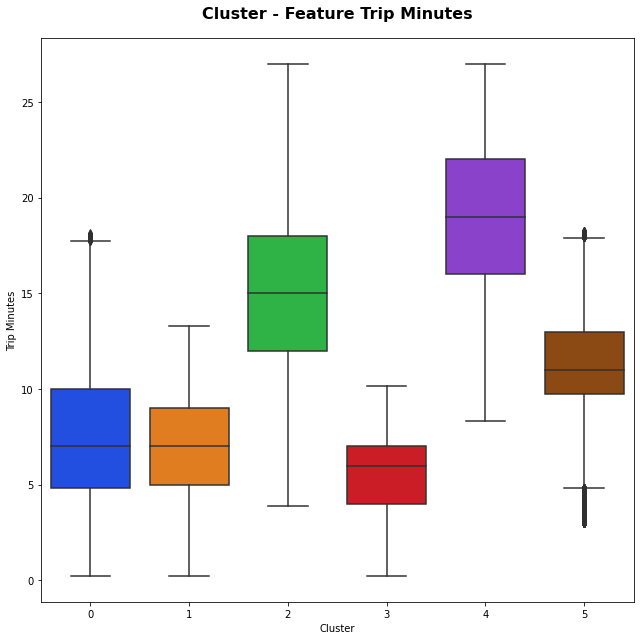

In [19]:
clustering.plot_clusters_boxplot(gmm_df, "Trip Minutes")

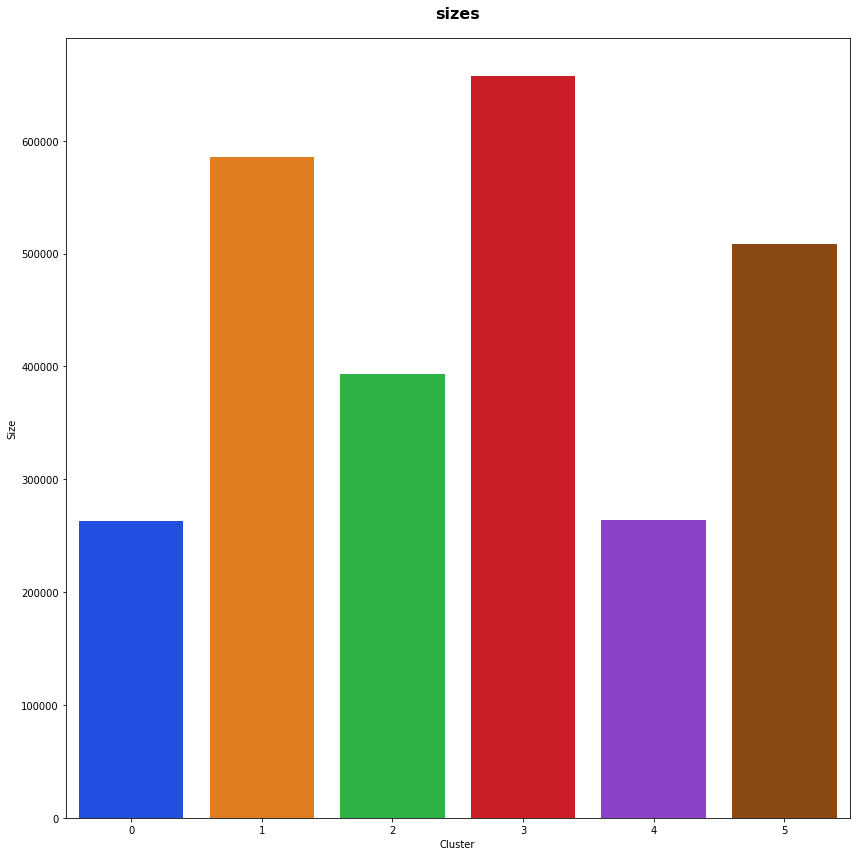

In [20]:
clustering.plot_clusters_sizes(gmm_df, "sizes")

In [21]:
gmm_df.head()


,Trip Kilometers,Trip Minutes,Trip Start Hour,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob
0,3.70,17.0000,17,2,7.431657e-53,0.006501,6.248976e-01,0.000026,0.076300,0.292275
1,1.77,6.0000,21,1,7.996620e-70,0.898052,1.057635e-02,0.089741,0.000002,0.001630
4,3.06,11.0000,9,5,1.089848e-12,0.000001,5.449355e-08,0.122422,0.018908,0.858669
5,2.41,11.0000,13,5,4.396857e-28,0.014064,3.942485e-04,0.254459,0.006202,0.724880
6,2.41,13.7167,9,5,4.197130e-16,0.000007,1.104244e-06,0.002236,0.122518,0.875237


### Hard-Clustering
---

#### K-Means

K-Means is a widely used iterative hard-clustering algorithm.
In contrast to soft-clustering algorithms, data points can only belong to a single cluster.
k local optima get computed and data points get allocated to it's nearest centroid.
Just like with GMM, an appropriate number of clusters has to be determined beforehand.

#### Determine number of clusters with Elbow-Method

For a good comparison between our soft- and hard-clustering results, taking also 6 clusters for
K-Means seems reasonable.
To further cross-validate this decision make use of the 'Elbow Method'.
The Elbow Method is a visualization of the distortion scores where k-Means is run k-times.
A good fit of k can be found, where the distortion starts decreasing linearly.

In [22]:
#Live version -> Very Long runtime
#clustering.get_elbow(scoring_df, 8)

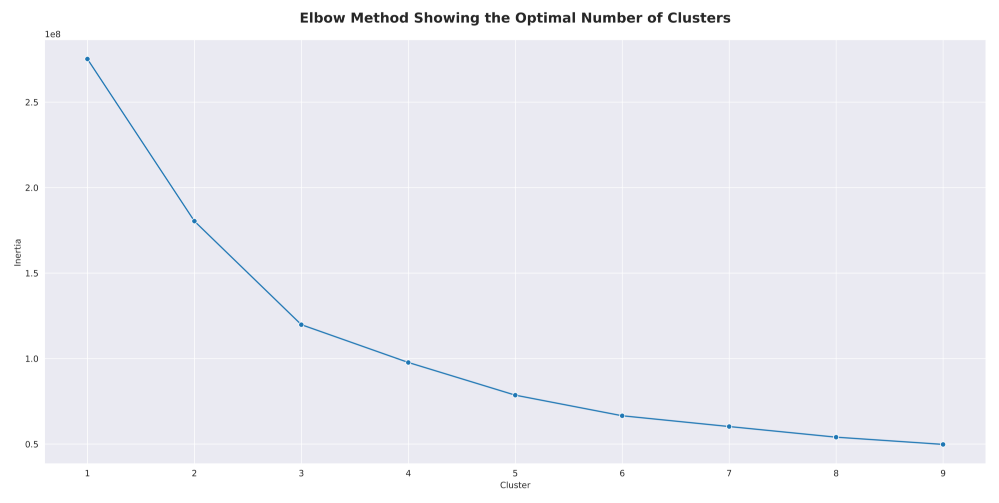

In [23]:
##Offline version -> Calculated with 10% data size
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))
elbow_graph = pilim.open('img/Elbow_8.png', 'r')
ax.imshow(np.asarray(elbow_graph))
ax.set_axis_off()
plt.show()

The so called 'Elbow' can be found at 3 clusters.
Even though, taking 6 clusters is also reasonable.
The curve starts to further flatten after 6 cluster, which means, that taking more clusters leads to over-fitting.

In [ ]:
# create copy of chicago_df_q to keep save from unintentional changes

kmeans_df = chicago_df_q.copy()
kmeans_df.info()

In [24]:
kmeans_df = clustering.get_clusters_kmeans(kmeans_df,
                 n_cluster=6,
                )


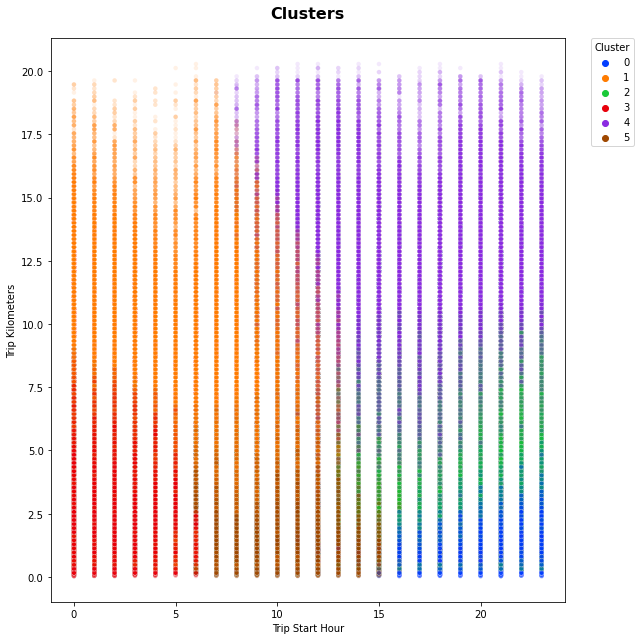

In [25]:
clustering.plot_clusters_scatter(kmeans_df, "Trip Start Hour", "Trip Kilometers", "Clusters", save_plot= True, save_name='Scatter_StartHour_Kilometer_Hard')

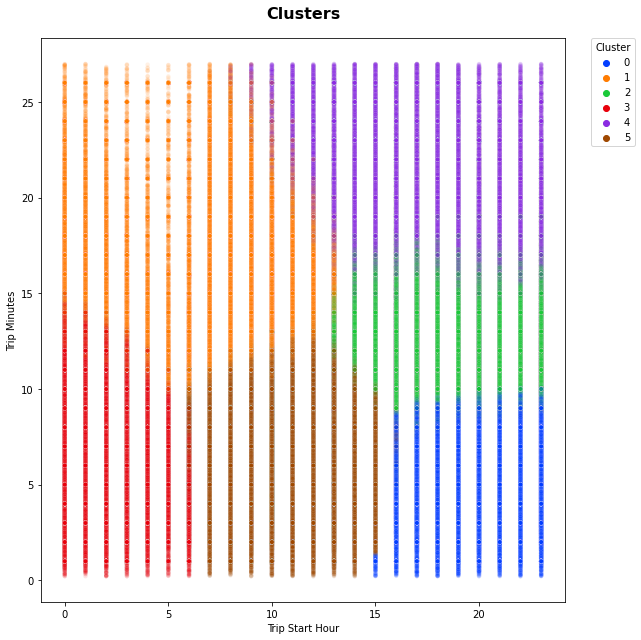

In [26]:
clustering.plot_clusters_scatter(kmeans_df, "Trip Start Hour", "Trip Minutes", "Clusters", save_plot= True, save_name='Scatter_StartHour_Minutes_Hard')

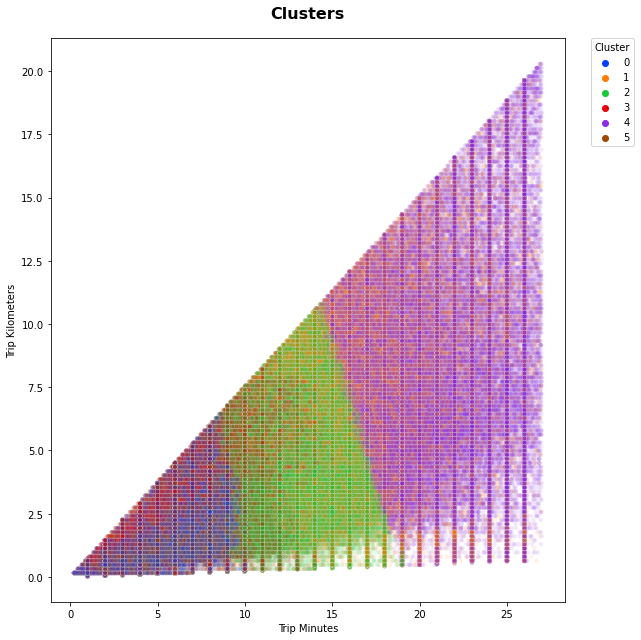

In [27]:
clustering.plot_clusters_scatter(kmeans_df, "Trip Minutes", "Trip Kilometers", "Clusters", save_plot= True, save_name='Scatter_Minutes_Kilometer_Hard')

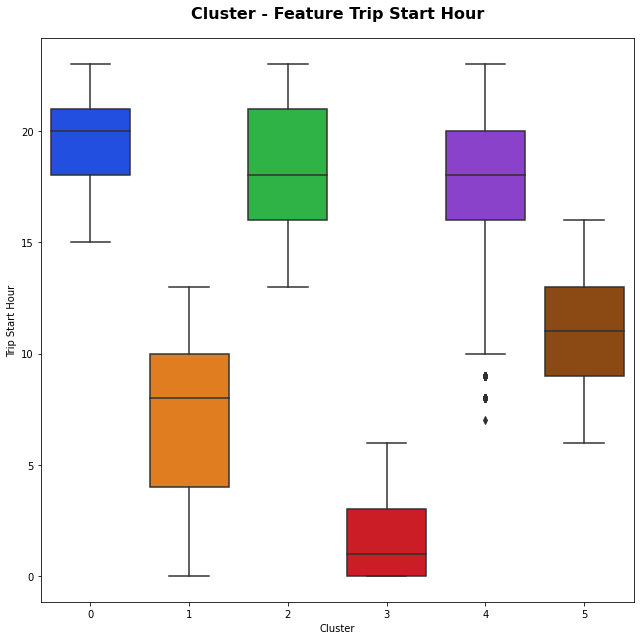

In [28]:
clustering.plot_clusters_boxplot(kmeans_df, "Trip Start Hour", save_plot= True, save_name='BoxPlot_StartHour_Hard')

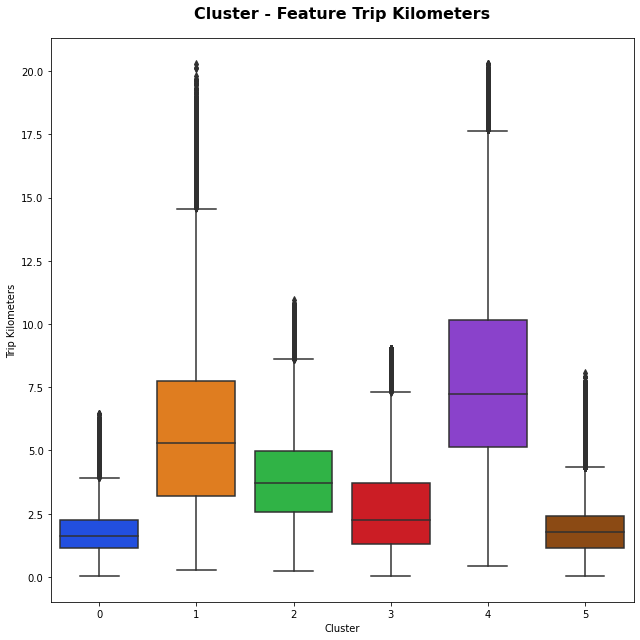

In [29]:
clustering.plot_clusters_boxplot(kmeans_df, "Trip Kilometers", save_plot= True, save_name='BoxPlot_Kilometer_Hard')

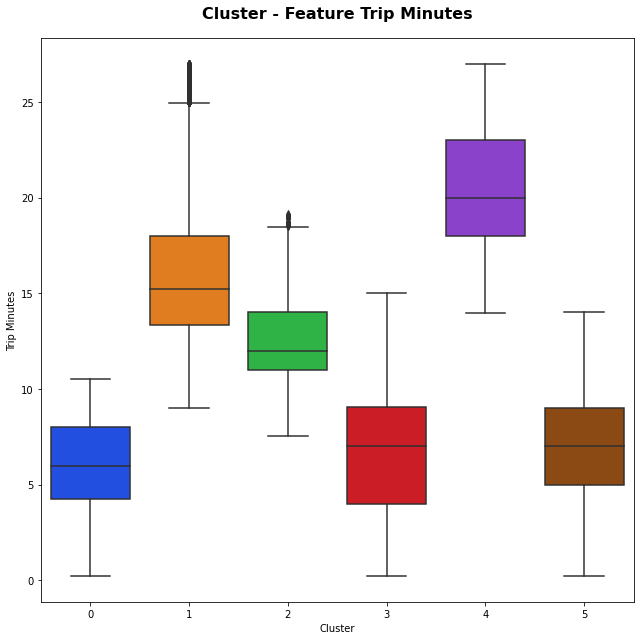

In [30]:
clustering.plot_clusters_boxplot(kmeans_df, "Trip Minutes", save_plot= True, save_name='BoxPlot_Minutes_Hard')


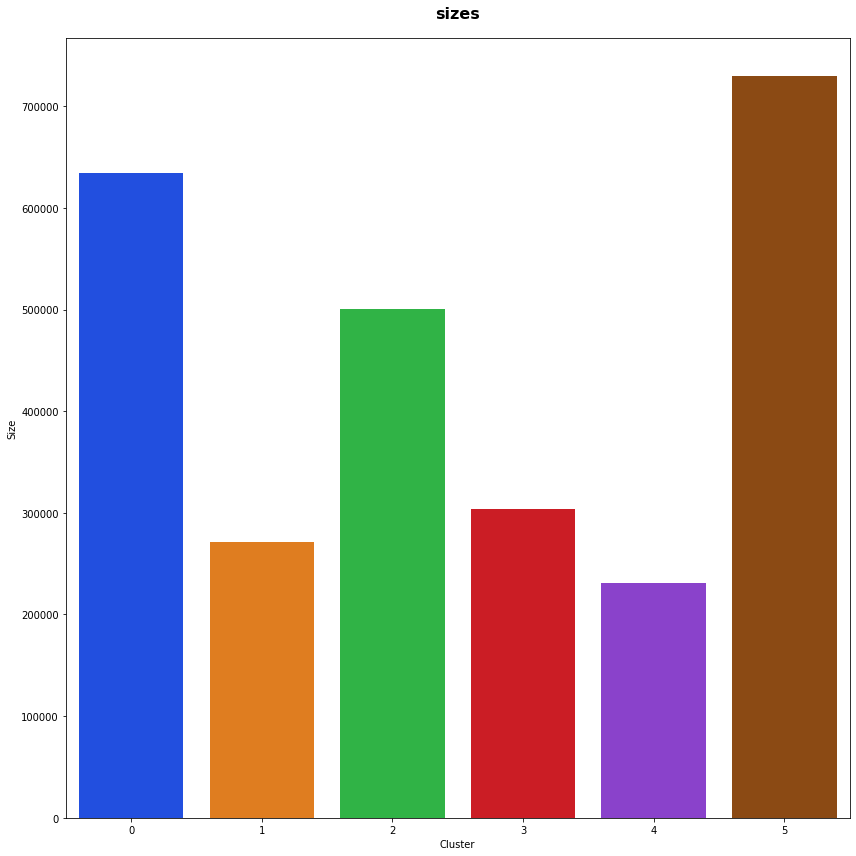

In [31]:
clustering.plot_clusters_sizes(kmeans_df, "sizes", save_plot= True, save_name='Sizes_StartHour_Kilometers_Minutes_Hard')

# 2. Cluster
---

# Data Preparation

In [56]:
chicago_df = utils.read_parquet('chicago_taxi_trips_15percent_sample.parquet',
                                columns=["Pickup Community Area", "Dropoff Community Area","Trip Kilometers", "Trip Minutes"])
chicago_df.head()

,Pickup Community Area,Dropoff Community Area,Trip Kilometers,Trip Minutes
0,33.0,32.0,3.70,17.0
1,32.0,8.0,1.77,6.0
2,28.0,3.0,12.23,27.0
3,32.0,8.0,0.16,9.0
4,8.0,32.0,3.06,11.0


In [57]:
chicago_df_q = feature_engineering.add_spatial_features(chicago_df, dropoff=True)

In [58]:
chicago_df_q.drop(["Pickup Community Area","Dropoff Community Area", "Airport Distance", "Airport Distance Dropoff"], inplace=True, axis=1)

In [59]:
chicago_df_q["Kilometer per Hour"] = (chicago_df_q["Trip Kilometers"]/(chicago_df_q["Trip Minutes"]/60)).round(2)

In [60]:
chicago_df_q.drop(["Trip Kilometers", "Trip Minutes"], inplace = True, axis=1)
chicago_df_q = chicago_df_q[(chicago_df_q["Kilometer per Hour"] < chicago_df_q["Kilometer per Hour"].quantile(0.95))]
chicago_df_q = chicago_df_q[(chicago_df_q["Kilometer per Hour"] > chicago_df_q["Kilometer per Hour"].quantile(0.10))]
chicago_df_q.head()

,City Center Distance,City Center Distance Dropoff,Kilometer per Hour
0,2.750789,0.369594,13.06
1,0.369594,2.146581,17.70
2,3.451436,9.722203,27.18
4,2.146581,0.369594,16.69
5,2.146581,0.369594,13.15


## Determine Number of Clusters

In [61]:
scoring_df = chicago_df_q.sample(frac =0.1, random_state=7)

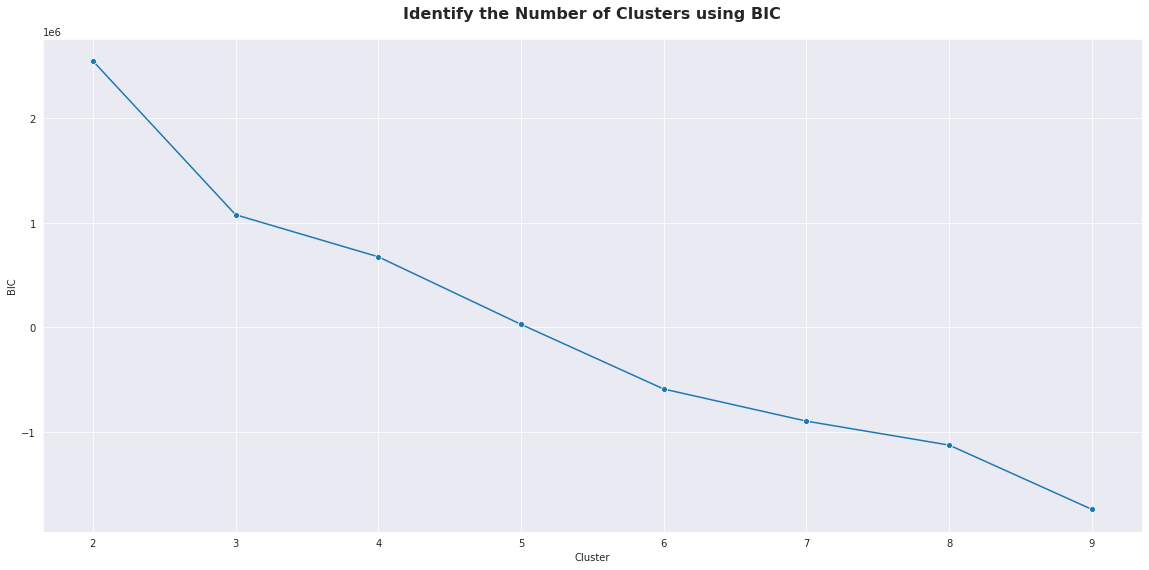

In [9]:
clustering.get_bic(scoring_df , 8, save_plot=True, save_name="bic_kmh")

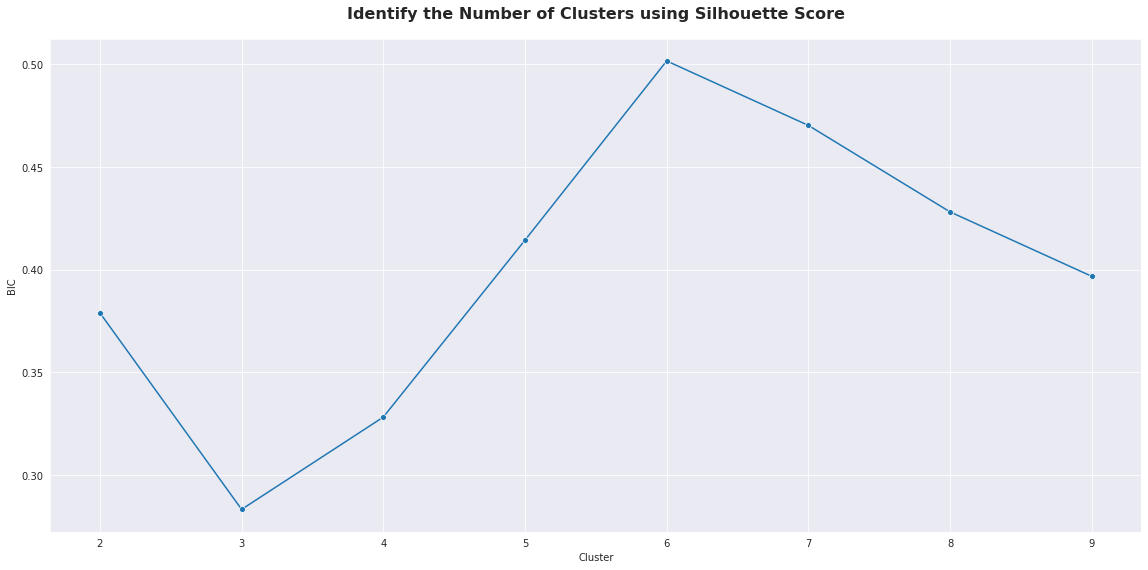

In [10]:
clustering.get_silhouette_score(scoring_df,8, save_plot=True, save_name="sscore_kmh")

## Soft Clustering

In [51]:
# create copy of chicago_df_q to keep save from unintentional changes

gmm_kmh_df = chicago_df_q.copy()
gmm_kmh_df.head()

,City Center Distance,City Center Distance Dropoff,Kilometer per Hour
2480390,7.450631,8.887403,20.90
2800941,0.369594,0.369594,18.45
1538174,0.369594,0.369594,8.70
594186,0.369594,7.450631,28.63
3194985,2.146581,3.451436,18.08


In [52]:
gmm_kmh_df = clustering.get_clusters_gmm(gmm_kmh_df,n_cluster=6)

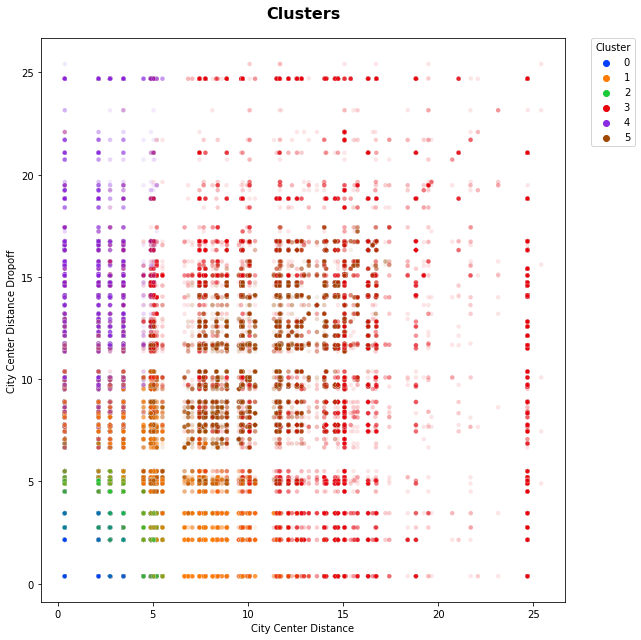

In [37]:
clustering.plot_clusters_scatter(gmm_kmh_df, "City Center Distance", "City Center Distance Dropoff",  "Clusters")

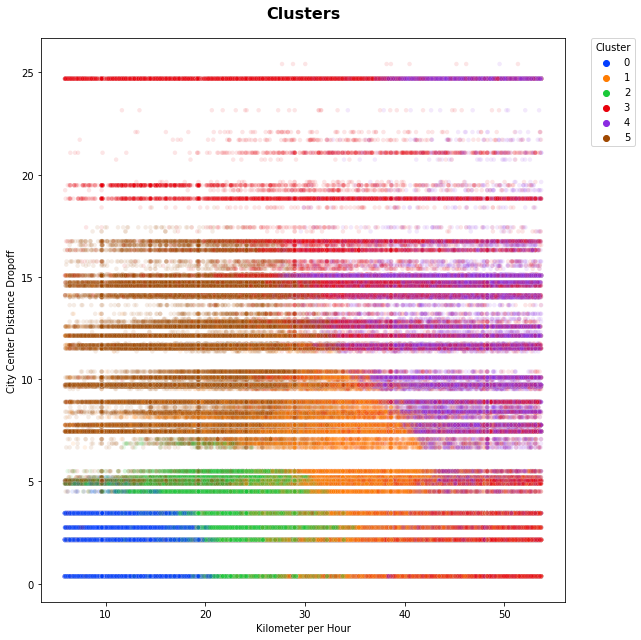

In [38]:
clustering.plot_clusters_scatter(gmm_kmh_df, "Kilometer per Hour", "City Center Distance Dropoff",  "Clusters")

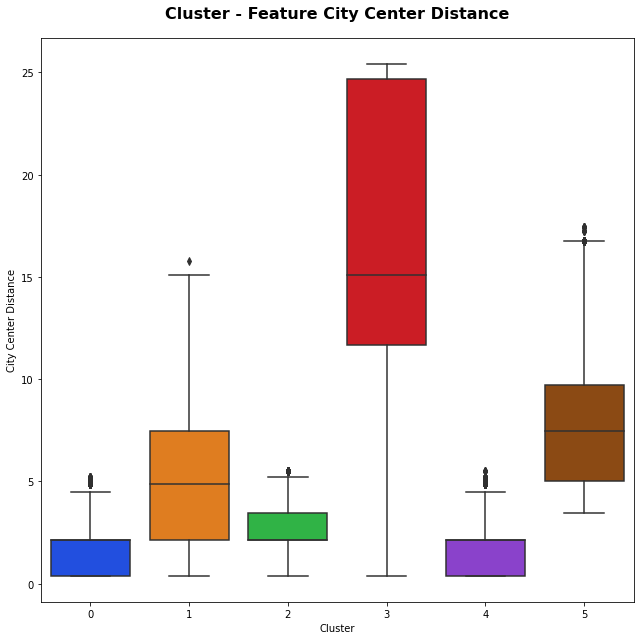

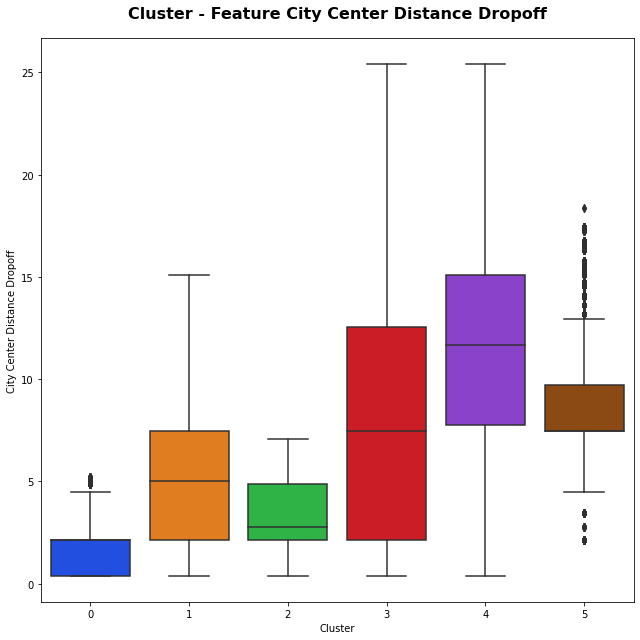

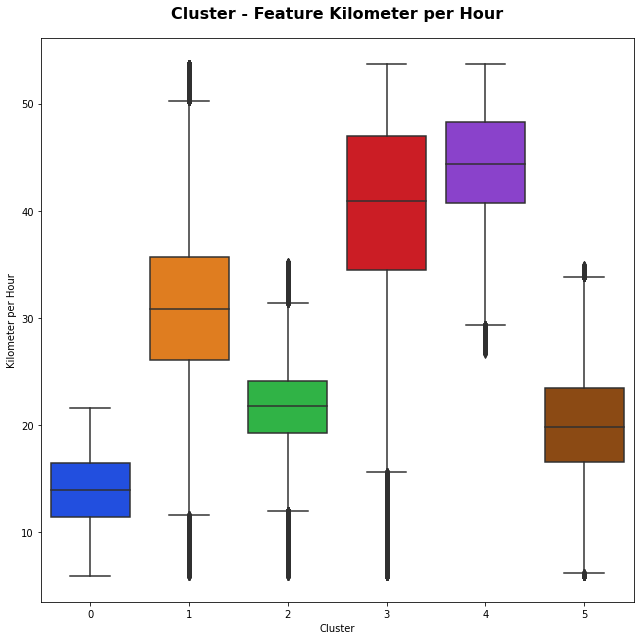

In [39]:
clustering.plot_clusters_boxplot(gmm_kmh_df, "City Center Distance", "Clusters")
clustering.plot_clusters_boxplot(gmm_kmh_df, "City Center Distance Dropoff", "Clusters")
clustering.plot_clusters_boxplot(gmm_kmh_df, "Kilometer per Hour", "Clusters")

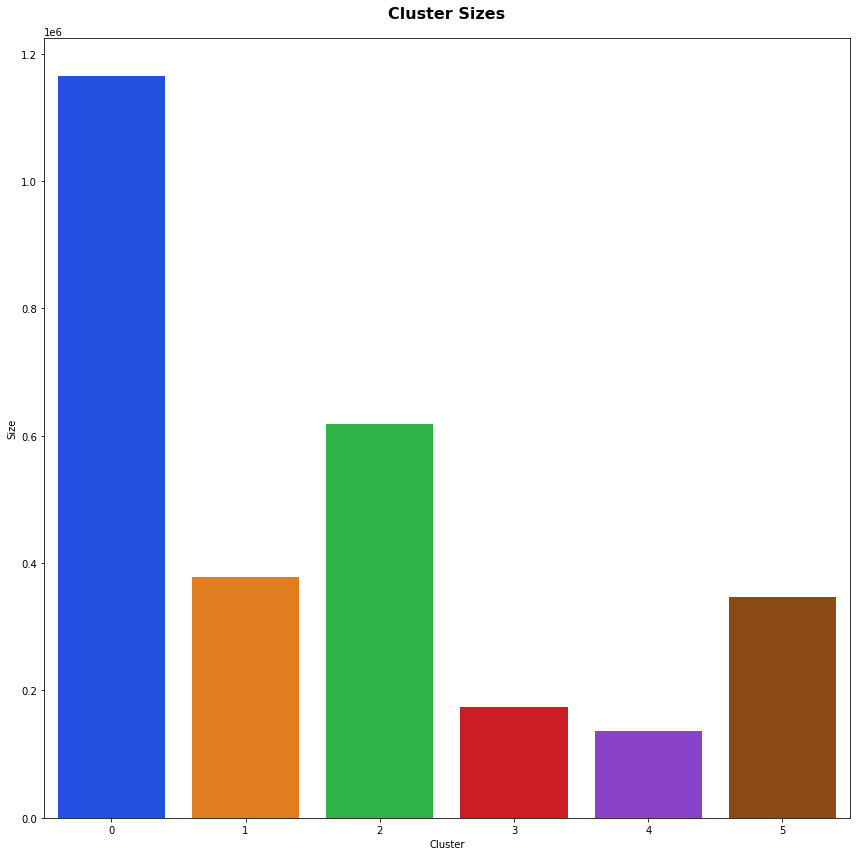

In [40]:
clustering.plot_clusters_sizes(gmm_kmh_df, "Cluster Sizes")

In [41]:
gmm_kmh_df.head()

,City Center Distance,City Center Distance Dropoff,Kilometer per Hour,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob
0,2.750789,0.369594,13.06,0,9.415698e-01,0.000186,0.051988,0.000003,7.965243e-08,0.006253
1,0.369594,2.146581,17.70,0,8.574541e-01,0.000389,0.133999,0.000013,2.325777e-06,0.008143
2,3.451436,9.722203,27.18,1,2.057128e-13,0.799231,0.000377,0.033768,1.660203e-02,0.150023
4,2.146581,0.369594,16.69,0,8.750117e-01,0.000267,0.116485,0.000008,1.566180e-06,0.008226
5,2.146581,0.369594,13.15,0,9.641239e-01,0.000074,0.031393,0.000002,8.717978e-08,0.004408


## Hard Clustering

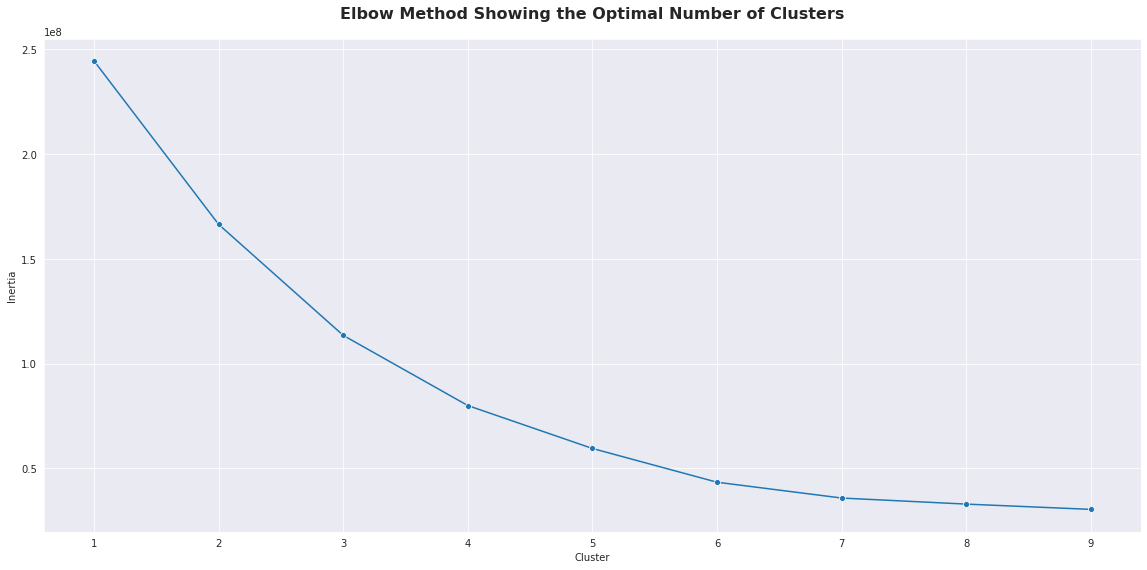

In [62]:
clustering.get_elbow(scoring_df, 8, save_plot=True, save_name="elbow_kmh")

In [63]:
# create copy of chicago_df_q to keep save from unintentional changes

kmeans_kmh_df = chicago_df_q.copy()
kmeans_kmh_df.head()

,City Center Distance,City Center Distance Dropoff,Kilometer per Hour
0,2.750789,0.369594,13.06
1,0.369594,2.146581,17.70
2,3.451436,9.722203,27.18
4,2.146581,0.369594,16.69
5,2.146581,0.369594,13.15


In [64]:
kmeans_kmh_df = clustering.get_clusters_kmeans(kmeans_kmh_df, 6)

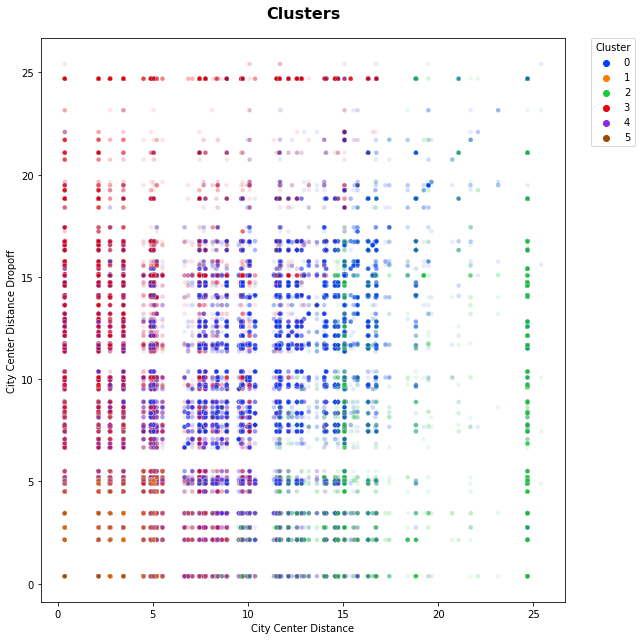

In [65]:
clustering.plot_clusters_scatter(kmeans_kmh_df, "City Center Distance", "City Center Distance Dropoff",  "Clusters")

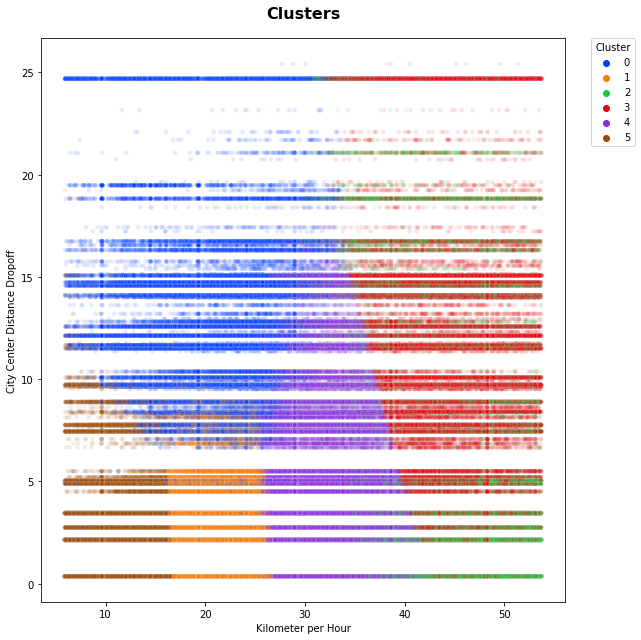

In [66]:
clustering.plot_clusters_scatter(kmeans_kmh_df, "Kilometer per Hour", "City Center Distance Dropoff",  "Clusters")

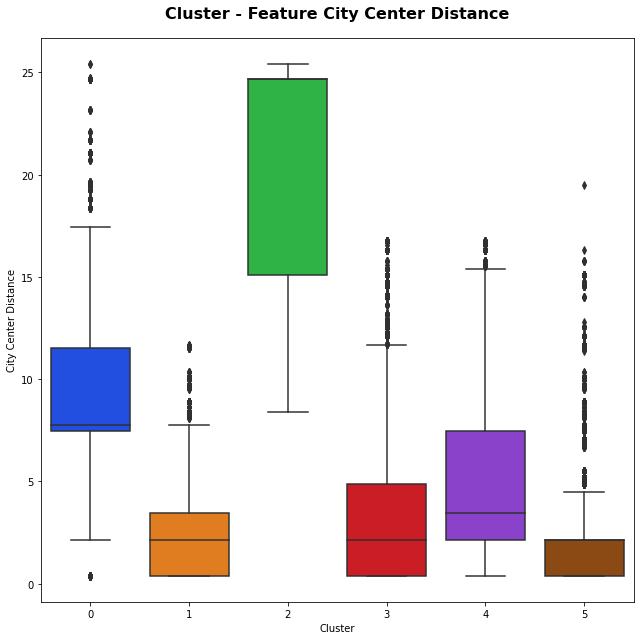

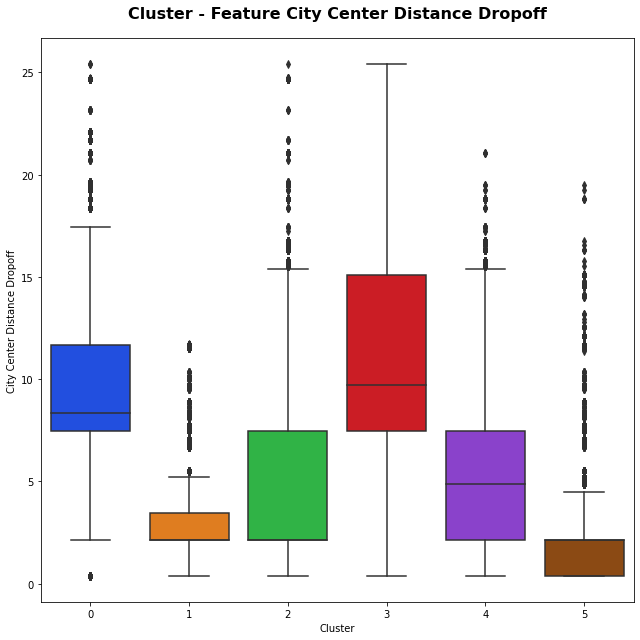

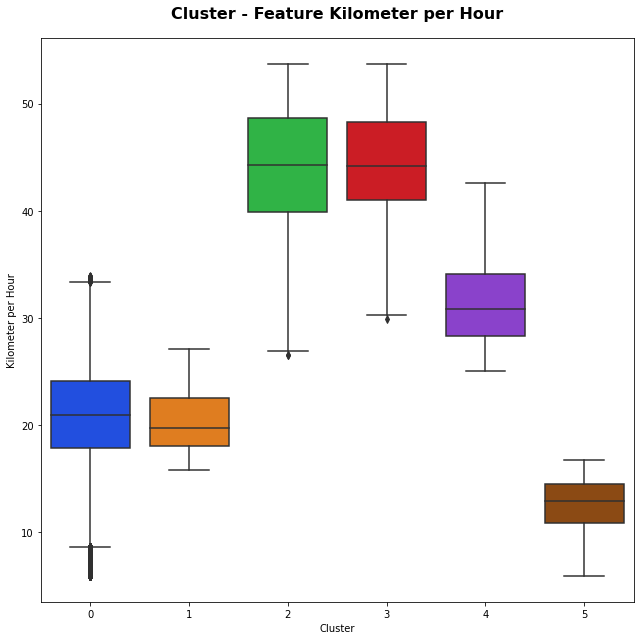

In [67]:
clustering.plot_clusters_boxplot(kmeans_kmh_df, "City Center Distance", "Clusters")
clustering.plot_clusters_boxplot(kmeans_kmh_df, "City Center Distance Dropoff", "Clusters")
clustering.plot_clusters_boxplot(kmeans_kmh_df, "Kilometer per Hour", "Clusters")

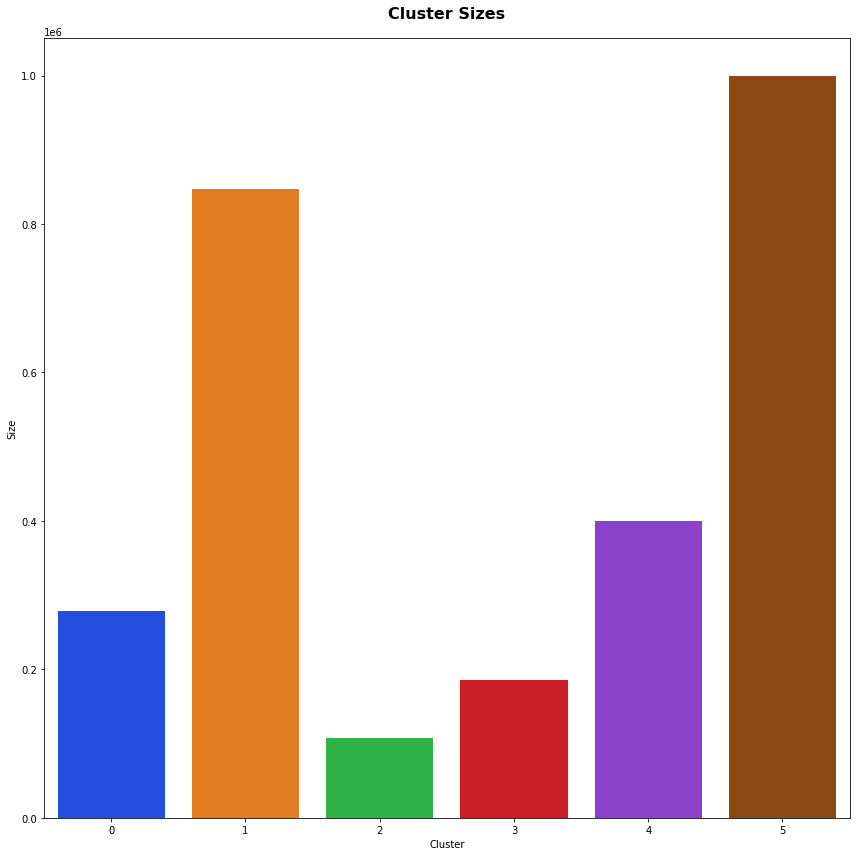

In [68]:
clustering.plot_clusters_sizes(kmeans_kmh_df, "Cluster Sizes")

In [69]:
kmeans_kmh_df.head()

,City Center Distance,City Center Distance Dropoff,Kilometer per Hour,cluster
0,2.750789,0.369594,13.06,5
1,0.369594,2.146581,17.70,1
2,3.451436,9.722203,27.18,4
4,2.146581,0.369594,16.69,1
5,2.146581,0.369594,13.15,5


In [70]:
kmeans_kmh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2817671 entries, 0 to 3295675
Data columns (total 4 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   City Center Distance          float64
 1   City Center Distance Dropoff  float64
 2   Kilometer per Hour            float64
 3   cluster                       int32  
dtypes: float64(3), int32(1)
memory usage: 96.7 MB
